Figure for comparing vis & motor

session 0
hidden states:  vis:3  motor 3

- firing rate in both vis & motor   Peng
- decoder using firing rates of both vis & motor to predict trial types (vis_stimuli & response)  Jing
- best num of hidden states in both vis & motor   Peng
- hidden states matrix, state sequencce, posterior prob, transition matrix  Peng
- statistical features in both vis & motor under different trial types  Yuyang
- connect hidden states with its actual meaning (stimuli direction in vis  Farnaz, move_direcction in motor  Ula)
- decoder using hidden states of both vis & motor to predict trial types (vis_stimuli & response)  Yidan, Jing
- (other areas) Ula

In [44]:
import random
import ssm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [2]:
# get all 39 sessions
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
                              
alldat.shape

(39,)

In [3]:
regions = ["vis ctx", "motor ctx", "other areas"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                [ "MOp", "MOs"],  # motor cortex
                ]

nareas = 2  # only consider vis ctx and motor ctx

# find good sessions, where vis_ctx neurons > 100 and motor_ctx neurons > 100
vis_neurons = np.zeros(len(alldat))
motor_neurons = np.zeros(len(alldat))

for i in range(len(alldat)):
    dat = alldat[i]   # a dict
    NN = len(dat['brain_area'])  # number of neurons 
    barea = nareas * np.ones(NN, )  # last one is "other" 
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign 0 to vis_ctx, 1 to motor_ctx

    areas, neurons = np.unique(barea, return_counts=True)

    if np.isin(0, areas):
        vis_neurons[i] = neurons[0]
        if np.isin(1, areas):   
            motor_neurons[i] = neurons[1]
    else:
        if np.isin(1, areas):   
            motor_neurons[i] = neurons[0]    
# print(f'vis_neurons:{vis_neurons}')
# print(f'motor_neurons:{motor_neurons}')

vis_motor_pair = np.vstack((vis_neurons, motor_neurons)).T
good_vis_motor_pair_id = np.argwhere(np.logical_and(vis_motor_pair[:, 0]>100, vis_motor_pair[:, 1]>100)).flatten()
print(good_vis_motor_pair_id)
good_vis_motor_pair = vis_motor_pair[good_vis_motor_pair_id]
print(good_vis_motor_pair)

[ 0  7 25]
[[178. 113.]
 [111. 112.]
 [162. 166.]]


Select a session contain many neurons from both vis_ctx and motor_ctx

In [4]:
dat = alldat[7]   # a dict
NN = len(dat['brain_area'])  # number of neurons 
barea = nareas * np.ones(NN, )  # last one is "other" 
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign 0 to vis_ctx, 1 to motor_ctx

vis_neurons_id = np.argwhere(barea==0).flatten()
motor_neurons_id = np.argwhere(barea==1).flatten()

print(len(vis_neurons_id))
print(len(motor_neurons_id))

111
112


In [5]:
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']
print(f'neural_activity:{neural_activity.shape}')

vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
vis_stim = vis_left - vis_right # right - nogo - left
response = dat['response']  # right - nogo - left (-1, 0, 1)

# trials types by visual stimuli
vis_left_id = vis_stim > 0
vis_no_id = vis_stim == 0
vis_right_id = vis_stim < 0

# trials types by response
resp_left_id = response > 0
resp_no_id = response == 0
resp_right_id = response < 0

# trials types by result
correct_id_left = np.logical_and(vis_left_id, resp_left_id)
correct_id_no = np.logical_and(vis_no_id, resp_no_id)
correct_id_right = np.logical_and(vis_right_id, resp_right_id)
correct_id = np.logical_or(correct_id_left, correct_id_no)
correct_id = np.logical_or(correct_id, correct_id_right)
incorrect_id = np.logical_not(correct_id)

neural_activity:(1156, 250, 250)


plot firing rate in vis_ctx & motor ctx

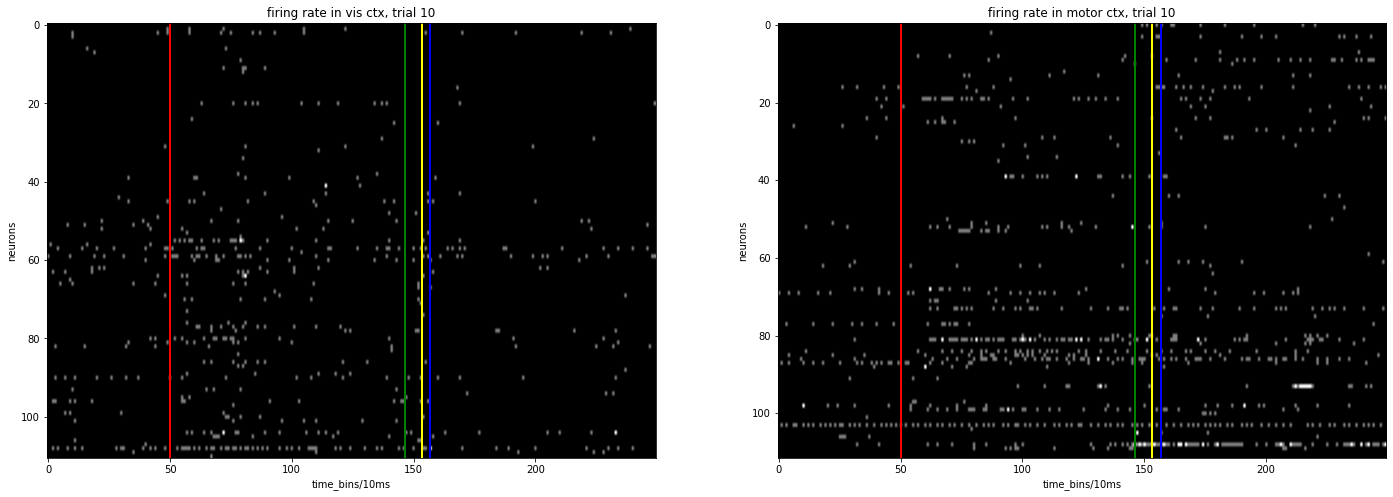

In [6]:
n_trial = 10
fig, axes = plt.subplots(ncols=2, figsize=(24, 8))

for i in range(nareas):

    neural_activity_area = neural_activity[barea==i]
    axes[i].imshow(neural_activity_area[:,n_trial,:], aspect='auto', cmap='gray')
    axes[i].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    axes[i].axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
    axes[i].axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
    axes[i].axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
    axes[i].set_ylabel("neurons")
    axes[i].set_xlabel("time_bins/10ms")
    axes[i].set_title(f'firing rate in {regions[i]}, trial {n_trial}')

plt.show()

decoder using firing rate from vis_ctx & motor_ctx

best num of hidden states in vis_ctx & motor_ctx

In [7]:
def Possion_HMM(input_data, num_states, num_features):

    p_hmm = ssm.HMM(num_states, num_features, observations="poisson")
    p_hmm.fit(input_data, method="em", num_iters = 100)
    hidden_states = p_hmm.most_likely_states(input_data)       # time_bins
    transition_matrix = p_hmm.transitions.transition_matrix    # num_states x num_states
    posterior_prob, _, _ = p_hmm.expected_states(input_data)   # posterior_prob: time_bins x num_states
    log_like = p_hmm.log_probability(input_data)

    return hidden_states, posterior_prob, transition_matrix, log_like

In [8]:
num_states = 3
hidden_states_areas = {}
posterior_prob_areas = {}
transition_matrix_areas = {}

for i in range(nareas):

    input_data = neural_activity[barea==i]
    num_neurons = input_data.shape[0]
    num_trials = input_data.shape[1]
    num_bins = input_data.shape[2]
    input_data = input_data.reshape(num_neurons, num_trials*num_bins)

    hidden_states, posterior_prob, transition_matrix, _ = Possion_HMM(input_data.T, num_states, num_neurons)

    hidden_states_areas[i] = hidden_states
    posterior_prob_areas[i] = posterior_prob
    transition_matrix_areas[i] = transition_matrix

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# decode trial type from HMM posterior

In [64]:
decoder_input = dict.fromkeys([0,1])
for i in range(nareas):
    input_data = neural_activity[barea==i]
    num_neurons = input_data.shape[0]
    num_trials = input_data.shape[1]
    num_bins = input_data.shape[2]
    
    reshaped_posterior = posterior_prob_areas[i].reshape(num_trials, num_bins, posterior_prob_areas[i].shape[1])
    averaged_posterior = reshaped_posterior.mean(1)
    
    decoder_input[i] = averaged_posterior

In [94]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [95]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(decoder_input[0], response, 
                                                            test_size=0.2, random_state=12345)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(decoder_input[1], response, 
                                                            test_size=0.2, random_state=12345)

In [96]:
# Logistic Regression
lr_model_1 = LogisticRegression(random_state=0).fit(X_train_1, y_train_1)
lr_model_2 = LogisticRegression(random_state=0).fit(X_train_2, y_train_2)
lr_model_1_score = lr_model_1.score(X_test_1, y_test_1)
lr_model_2_score = lr_model_2.score(X_test_2, y_test_2)
print(f"LR Model Accuracy Area Visual: {lr_model_1_score}")
print(f"LR Model Accuracy Area Motor: {lr_model_2_score}")

LR Model Accuracy Area Visual: 0.52
LR Model Accuracy Area Motor: 0.76


In [97]:
forest_model_1 = RandomForestClassifier().fit(X_train_1, y_train_1)
forest_model_2 = RandomForestClassifier().fit(X_train_2, y_train_2)
forest_model_1_score = forest_model_1.score(X_test_1, y_test_1)
forest_model_2_score = forest_model_2.score(X_test_2, y_test_2)
print(f"RF Model Accuracy Area Visual: {forest_model_1_score}")
print(f"RF Model Accuracy Area Motor: {forest_model_2_score}")

RF Model Accuracy Area Visual: 0.6
RF Model Accuracy Area Motor: 0.62


In [98]:
dummy_model_1 = DummyClassifier().fit(X_train_1, y_train_1)
dummy_model_2 = DummyClassifier().fit(X_train_2, y_train_2)
dummy_model_1_score = dummy_model_1.score(X_test_1, y_test_1)
dummy_model_2_score = dummy_model_2.score(X_test_2, y_test_2)
print(f"Dummy Model Accuracy Area Visual: {dummy_model_1_score}")
print(f"Dummy Model Accuracy Area Motor: {dummy_model_2_score}")

Dummy Model Accuracy Area Visual: 0.34
Dummy Model Accuracy Area Motor: 0.34


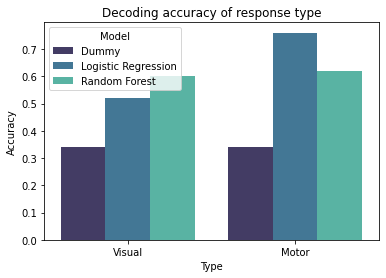

In [168]:
trial_type_decode = {'Type': ['Visual', 'Visual', 'Visual', 'Motor', 'Motor', 'Motor'], 
        'Model': ['Dummy', 'Logistic Regression', 'Random Forest', 'Dummy', 'Logistic Regression', 'Random Forest'], 
        'Accuracy': [dummy_model_1_score, lr_model_1_score, forest_model_1_score, 
                     dummy_model_2_score, lr_model_2_score, forest_model_2_score]}
trial_type_df = pd.DataFrame(trial_type_decode)
ax = sns.barplot(x="Type", y="Accuracy", hue="Model", palette = 'mako',
                 data=trial_type_df).set(title='Decoding accuracy of response type')

# decode visual cue from HMM posterior

In [141]:
def label_vis_stim(vis_stim):
    vis_stim_label = []
    for i in vis_stim:
        if i > 0:
            vis_stim_label.append(1)
        elif i == 0:
            vis_stim_label.append(0)
        elif i < 0:
            vis_stim_label.append(-1)
    return vis_stim_label

vis_stim_label = label_vis_stim(vis_stim)

In [142]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(decoder_input[0], vis_stim_label, 
                                                            test_size=0.2, random_state=12345)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(decoder_input[1], vis_stim_label, 
                                                            test_size=0.2, random_state=12345)

In [148]:
# Logistic Regression
lr_model_3 = LogisticRegression().fit(X_train_3, y_train_3)
lr_model_4 = LogisticRegression().fit(X_train_4, y_train_4)
lr_model_3_score = lr_model_3.score(X_test_3, y_test_3)
lr_model_4_score = lr_model_4.score(X_test_4, y_test_4)
print(f"LR Model Accuracy Area Visual: {lr_model_3_score}")
print(f"LR Model Accuracy Area Motor: {lr_model_4_score}")

LR Model Accuracy Area Visual: 0.5
LR Model Accuracy Area Motor: 0.5


In [149]:
forest_model_3 = RandomForestClassifier().fit(X_train_3, y_train_3)
forest_model_4 = RandomForestClassifier().fit(X_train_4, y_train_4)
forest_model_3_score = forest_model_3.score(X_test_3, y_test_3)
forest_model_4_score = forest_model_4.score(X_test_4, y_test_4)
print(f"RF Model Accuracy Area Visual: {forest_model_3_score}")
print(f"RF Model Accuracy Area Motor: {forest_model_4_score}")

RF Model Accuracy Area Visual: 0.56
RF Model Accuracy Area Motor: 0.32


In [150]:
dummy_model_3 = DummyClassifier().fit(X_train_3, y_train_3)
dummy_model_4 = DummyClassifier().fit(X_train_4, y_train_4)
dummy_model_3_score = dummy_model_3.score(X_test_3, y_test_3)
dummy_model_4_score = dummy_model_4.score(X_test_4, y_test_4)
print(f"Dummy Model Accuracy Area Visual: {dummy_model_1_score}")
print(f"Dummy Model Accuracy Area Motor: {dummy_model_2_score}")

Dummy Model Accuracy Area Visual: 0.34
Dummy Model Accuracy Area Motor: 0.34


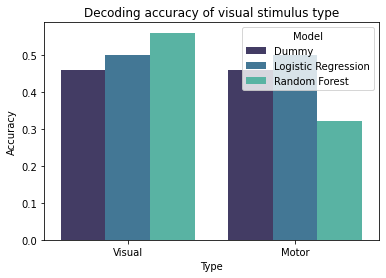

In [169]:
visual_cue_decode = {'Type': ['Visual', 'Visual', 'Visual', 'Motor', 'Motor', 'Motor'], 
        'Model': ['Dummy', 'Logistic Regression', 'Random Forest', 'Dummy', 'Logistic Regression', 'Random Forest'], 
        'Accuracy': [dummy_model_3_score, lr_model_3_score, forest_model_3_score, 
                     dummy_model_4_score, lr_model_4_score, forest_model_4_score]}
visual_cue_df = pd.DataFrame(visual_cue_decode)
ax = sns.barplot(x="Type", y="Accuracy", hue="Model", palette = 'mako', 
                 data=visual_cue_df).set(title='Decoding accuracy of visual stimulus type')

# Irrelevant for now 

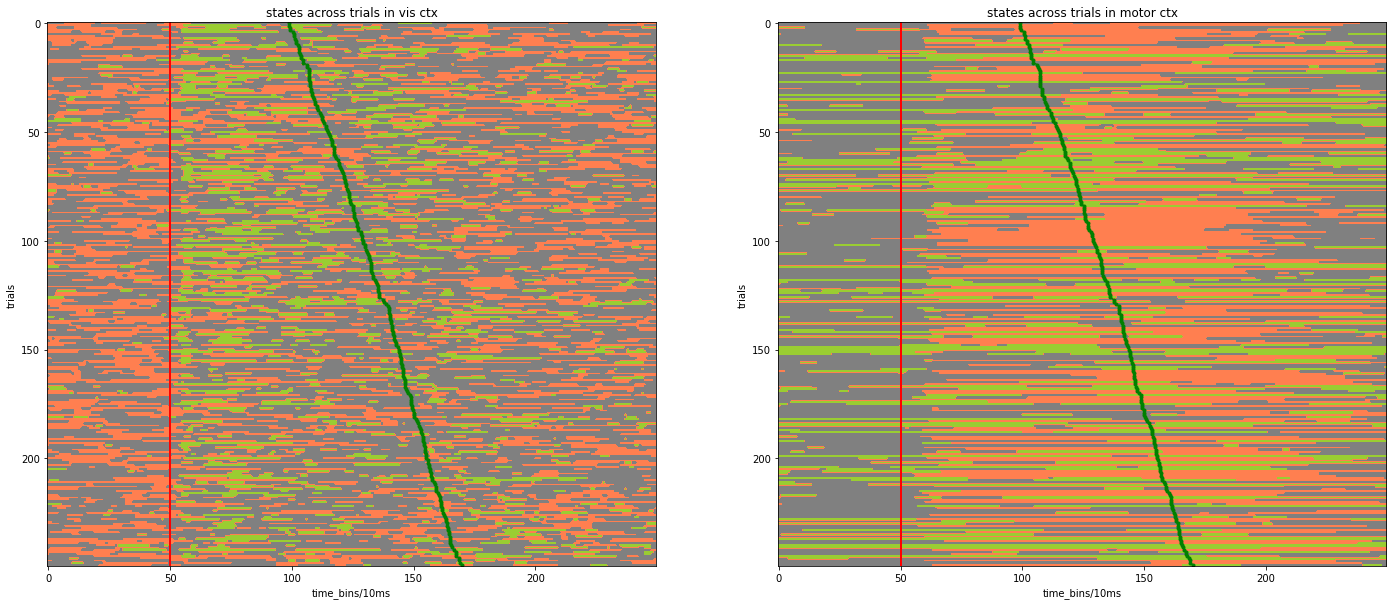

In [9]:
f, axes = plt.subplots(ncols=nareas, figsize=(24, 10))

for i in range(nareas):

    input_data = neural_activity[barea==i]
    num_neurons = input_data.shape[0]
    num_trials = input_data.shape[1]
    num_bins = input_data.shape[2]

    states_mat = hidden_states_areas[i].reshape(num_trials, num_bins)
    go_cue_array = gocue/bin_size
    go_cue_array = go_cue_array.flatten()
    go_cue_idx = np.argsort(go_cue_array)

    go_cue_sorted = go_cue_array[go_cue_idx]
    states_mat_sorted = states_mat[go_cue_idx, :]

    cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
    axes[i].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
    axes[i].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    axes[i].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
    axes[i].set_ylabel("trials")
    axes[i].set_xlabel("time_bins/10ms")
    axes[i].set_title(f'states across trials in {regions[i]}')

plt.tight_layout
plt.show()

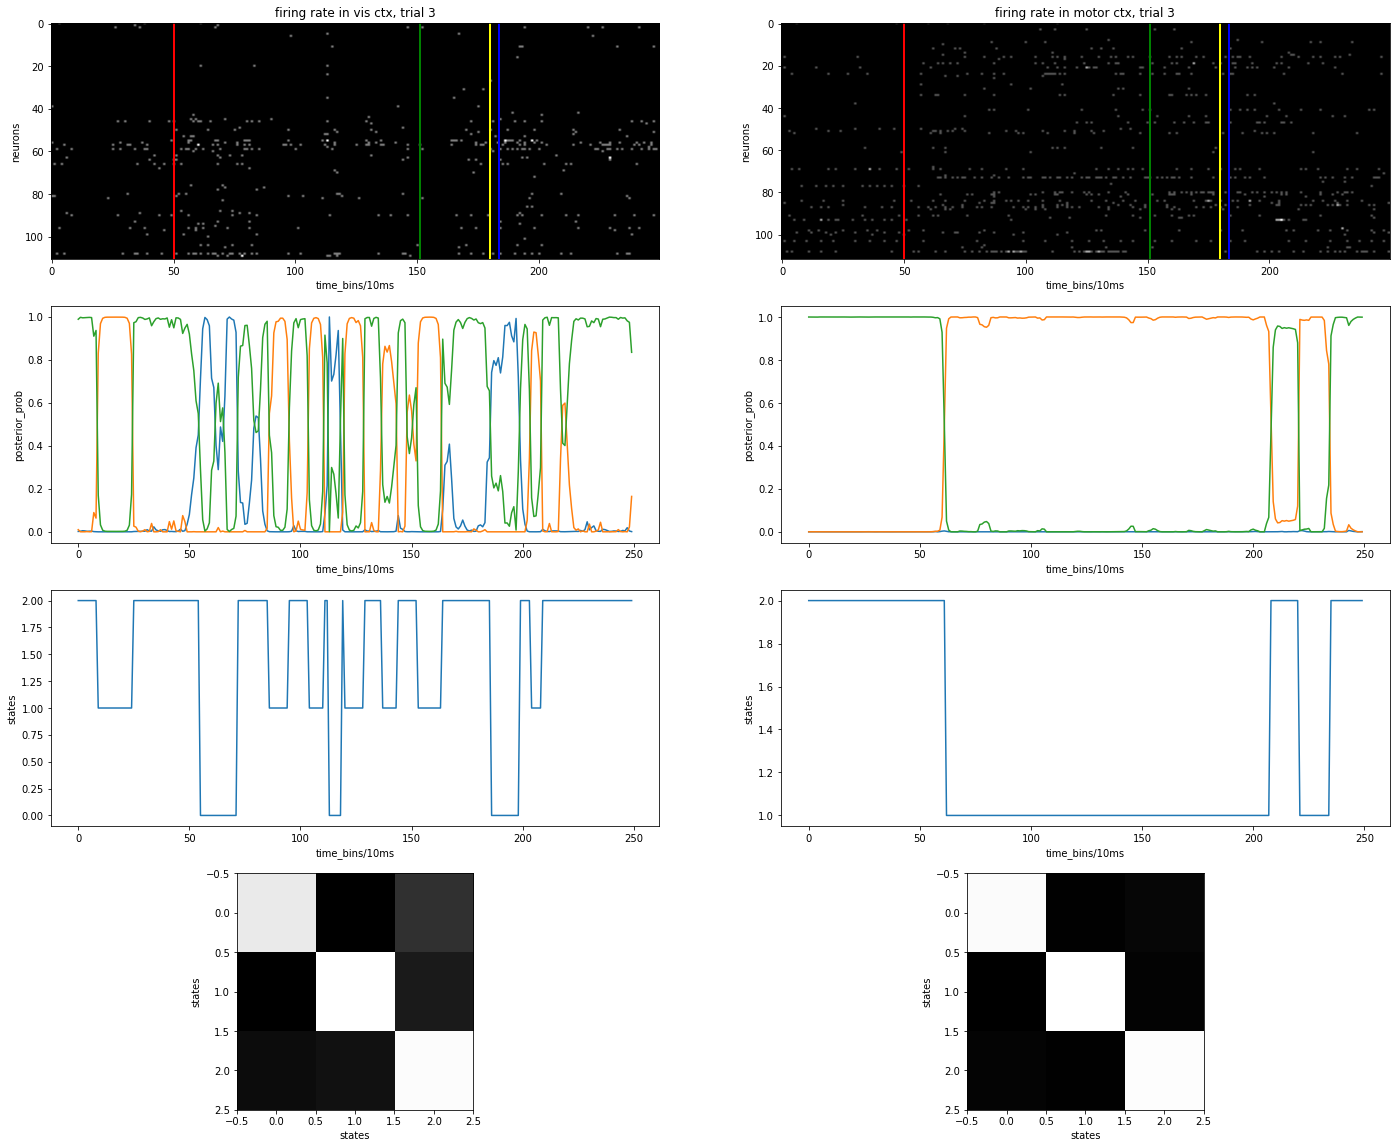

In [10]:
n_trial = 3
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(24,20))

for i in range(nareas):

    neural_activity_area = neural_activity[barea==i]
    axes[0][i].imshow(neural_activity_area[:,n_trial,:], aspect='auto', cmap='gray')
    axes[0][i].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    axes[0][i].axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
    axes[0][i].axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
    axes[0][i].axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
    axes[0][i].set_ylabel("neurons")
    axes[0][i].set_xlabel("time_bins/10ms")
    axes[0][i].set_title(f'firing rate in {regions[i]}, trial {n_trial}')
    
    num_neurons = neural_activity_area.shape[0]
    num_trials = neural_activity_area.shape[1]
    num_bins = neural_activity_area.shape[2]
    states_mat = hidden_states_areas[i].reshape(num_trials, num_bins)
    posterior_prob_mat = posterior_prob_areas[i].reshape(num_trials, num_bins, num_states)

    axes[1][i].plot(posterior_prob_mat[n_trial])
    axes[1][i].set_ylabel("posterior_prob")
    axes[1][i].set_xlabel("time_bins/10ms")

    axes[2][i].plot(states_mat[n_trial])
    axes[2][i].set_ylabel("states")
    axes[2][i].set_xlabel("time_bins/10ms")

    axes[3][i].imshow(transition_matrix_areas[i], cmap='gray')
    axes[3][i].set_ylabel("states")
    axes[3][i].set_xlabel("states")

plt.show()

In [11]:
n_folds = 5
max_states = 8
kf = KFold(n_splits=n_folds, shuffle=True, random_state=None)

ll_training = np.zeros((nareas, max_states, n_folds))
ll_testing = np.zeros((nareas, max_states, n_folds))
BIC_testing = np.zeros((nareas, max_states, n_folds))

hmm_z_ms = np.zeros((nareas, max_states, num_trials*num_bins))

for i in range(nareas):

    input_data = neural_activity[barea==i]
    num_neurons = input_data.shape[0]
    num_trials = input_data.shape[1]
    num_bins = input_data.shape[2]
    input_data = input_data.reshape(num_neurons, num_trials*num_bins)
    input_data = input_data.T

    for j, num_states in enumerate(range(1, max_states+1)):
        #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
        num_para = num_states*num_states + num_states*num_neurons + num_states*num_neurons

        for k, (train_index, test_index) in enumerate(kf.split(input_data)):
            print(f"kfold {k} TRAIN:", len(train_index), "TEST:", len(test_index))

            n_train = len(train_index)
            n_test = len(test_index)
            
            #Split data
            train_data = input_data[train_index]
            test_data = input_data[test_index]

            p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
            p_hmm.fit(train_data, method="em", num_iters=100)
            ll_training[i, j, k] = p_hmm.log_probability(train_data)/n_train
            ll_testing[i, j, k] = p_hmm.log_probability(test_data)/n_test
            
            #calculate the BIC
            BIC_testing[i, j, k] = num_para*np.log(n_test) - 2*p_hmm.log_probability(test_data)
            
        # #Let's do a full model fit and get the state-sequence
        # p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
        # p_hmm.fit(input_data, method="em", num_iters=100)
        # most_likely_states = p_hmm.most_likely_states(input_data)
        # hmm_z_ms[j,:] = p_hmm.most_likely_states(input_data)

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 0 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 1 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 2 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 3 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

kfold 4 TRAIN: 50000 TEST: 12500


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
##===== plot the heldout and training log-likelihoods and compare =====##

fig, axes = plt.subplots(3, 2, figsize=(20,18))

for i in range(nareas):

    #Training data
    axes[0][i].plot(np.arange(1, max_states+1), ll_training[i], '.')
    axes[0][i].plot(np.arange(1, max_states+1), np.mean(ll_training[i], axis=1),'-ok')
    axes[0][i].set_title('Training Log-likelihood in {regions[i]}')
    axes[0][i].set_ylabel('Log-likelihood / data-point')
    axes[0][i].set_xticks(np.arange(1, max_states+1))
    axes[0][i].set_xlabel('Number of States')

    axes[1][i].plot(np.arange(1, max_states+1), ll_testing[i], '.')
    axes[1][i].plot(np.arange(1, max_states+1), np.mean(ll_testing[i], axis=1), '-ok')
    axes[1][i].set_title('Test Log-likelihood')
    axes[1][i].set_ylabel('Log-likelihood / data-point')
    axes[1][i].set_xticks(np.arange(1, max_states+1))
    axes[1][i].set_xlabel('Number of States')

    axes[2][i].plot(np.arange(1, max_states+1), BIC_testing[i], '.')
    axes[2][i].plot(np.arange(1, max_states+1), np.mean(BIC_testing[i], axis=1), '-ok')
    axes[2][i].set_title('Test Bayesian Information Criterion')
    axes[2][i].set_ylabel('BIC')
    axes[2][i].set_xticks(np.arange(1, max_states+1))
    axes[2][i].set_xlabel('Number of States')

plt.show()
